## MultiClassification Documentation 

This notebook demostrates how to use `skexplain` for multiclassification problems. Multiclassification problems are a mode of classification where the output can be more than 2 classes. This is not to be confused with multioutput algorithms that produce more a single output. `skexplain` handles multiclassification in a simple way that the class to be evaluated is used as an input argument and then the user can iterate over the different classes. 

In [1]:
# Create a multiclassification model from the Iris dataset in Sklearn. 
import sys, os 
sys.path.insert(0, os.path.dirname(os.getcwd()))

import skexplain 
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
import numpy as np
import shap 

X,y = load_iris(return_X_y=True, as_frame=True)
lr = LogisticRegression().fit(X,y)

### MultiClass Permutation Importance 

In this example, we will compute the permutation importance using the ranked probability skill score (RPSS; a higher dimensional version of the Brier skill score). Scoring strategy is set to `minimize` since lower the RPSS would indicate an important feature. `rpss` is a built-in evaluation function, but you can also you a custom function. Check out the documentation on the Permutation Importance. 

In [2]:
explainer = skexplain.ExplainToolkit(('LogisticRegression', lr), X=X, y=y,)

In [3]:
results = explainer.permutation_importance(
                                           n_vars=X.shape[1], 
                                           evaluation_fn="rpss",
                                           scoring_strategy='minimize',
                                           n_permute=5, 
                                           subsample=1.0,
                                           n_jobs=X.shape[1],
                                           verbose=True,
                                           random_seed=42, 
                                           direction='backward',
                                              )

# Save the permutation importance results as a netcdf file using the bulit-in function within scikit-explain
#explainer.save(fname='../tutorial_data/multipass_importance_naupdc.nc', data=results)

Perm. Imp.: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 31.34it/s]


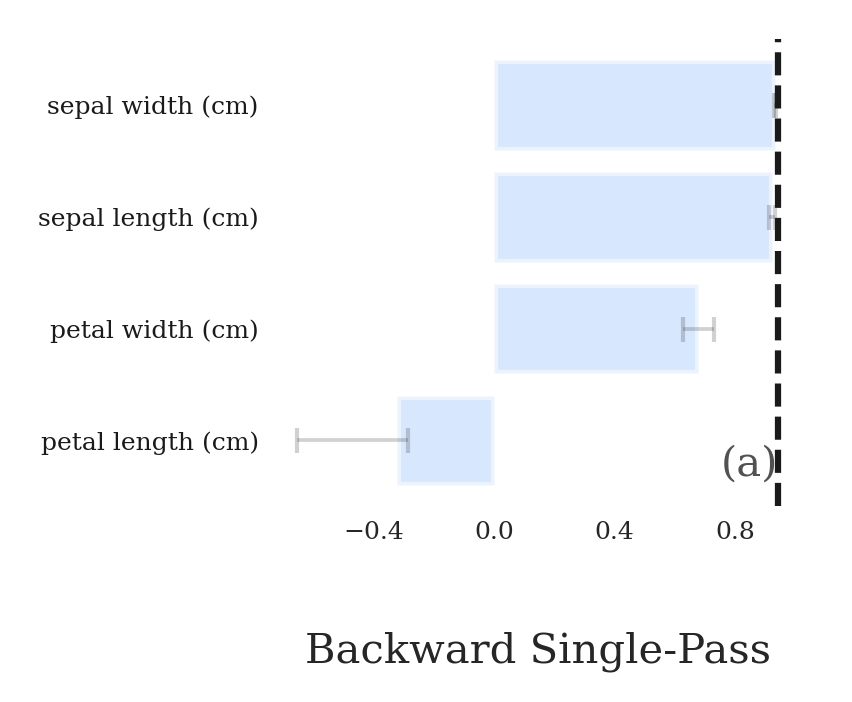

In [4]:
fig = explainer.plot_importance(data=results, 
                                panels=[('backward_singlepass', 'LogisticRegression')], 
                                num_vars_to_plot=15, 
                                 )

### MultiClass ALE 

In this example, we will compute the ALE curve for a given feature and demostrate how that feature contributes to each class. 

In [5]:
ales = [explainer.ale(features='all', n_bootstrap=1, n_jobs=4, n_bins=20, class_index=class_idx)
            for class_idx in np.unique(y)]

ALE Numerical Features: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 86.75it/s]


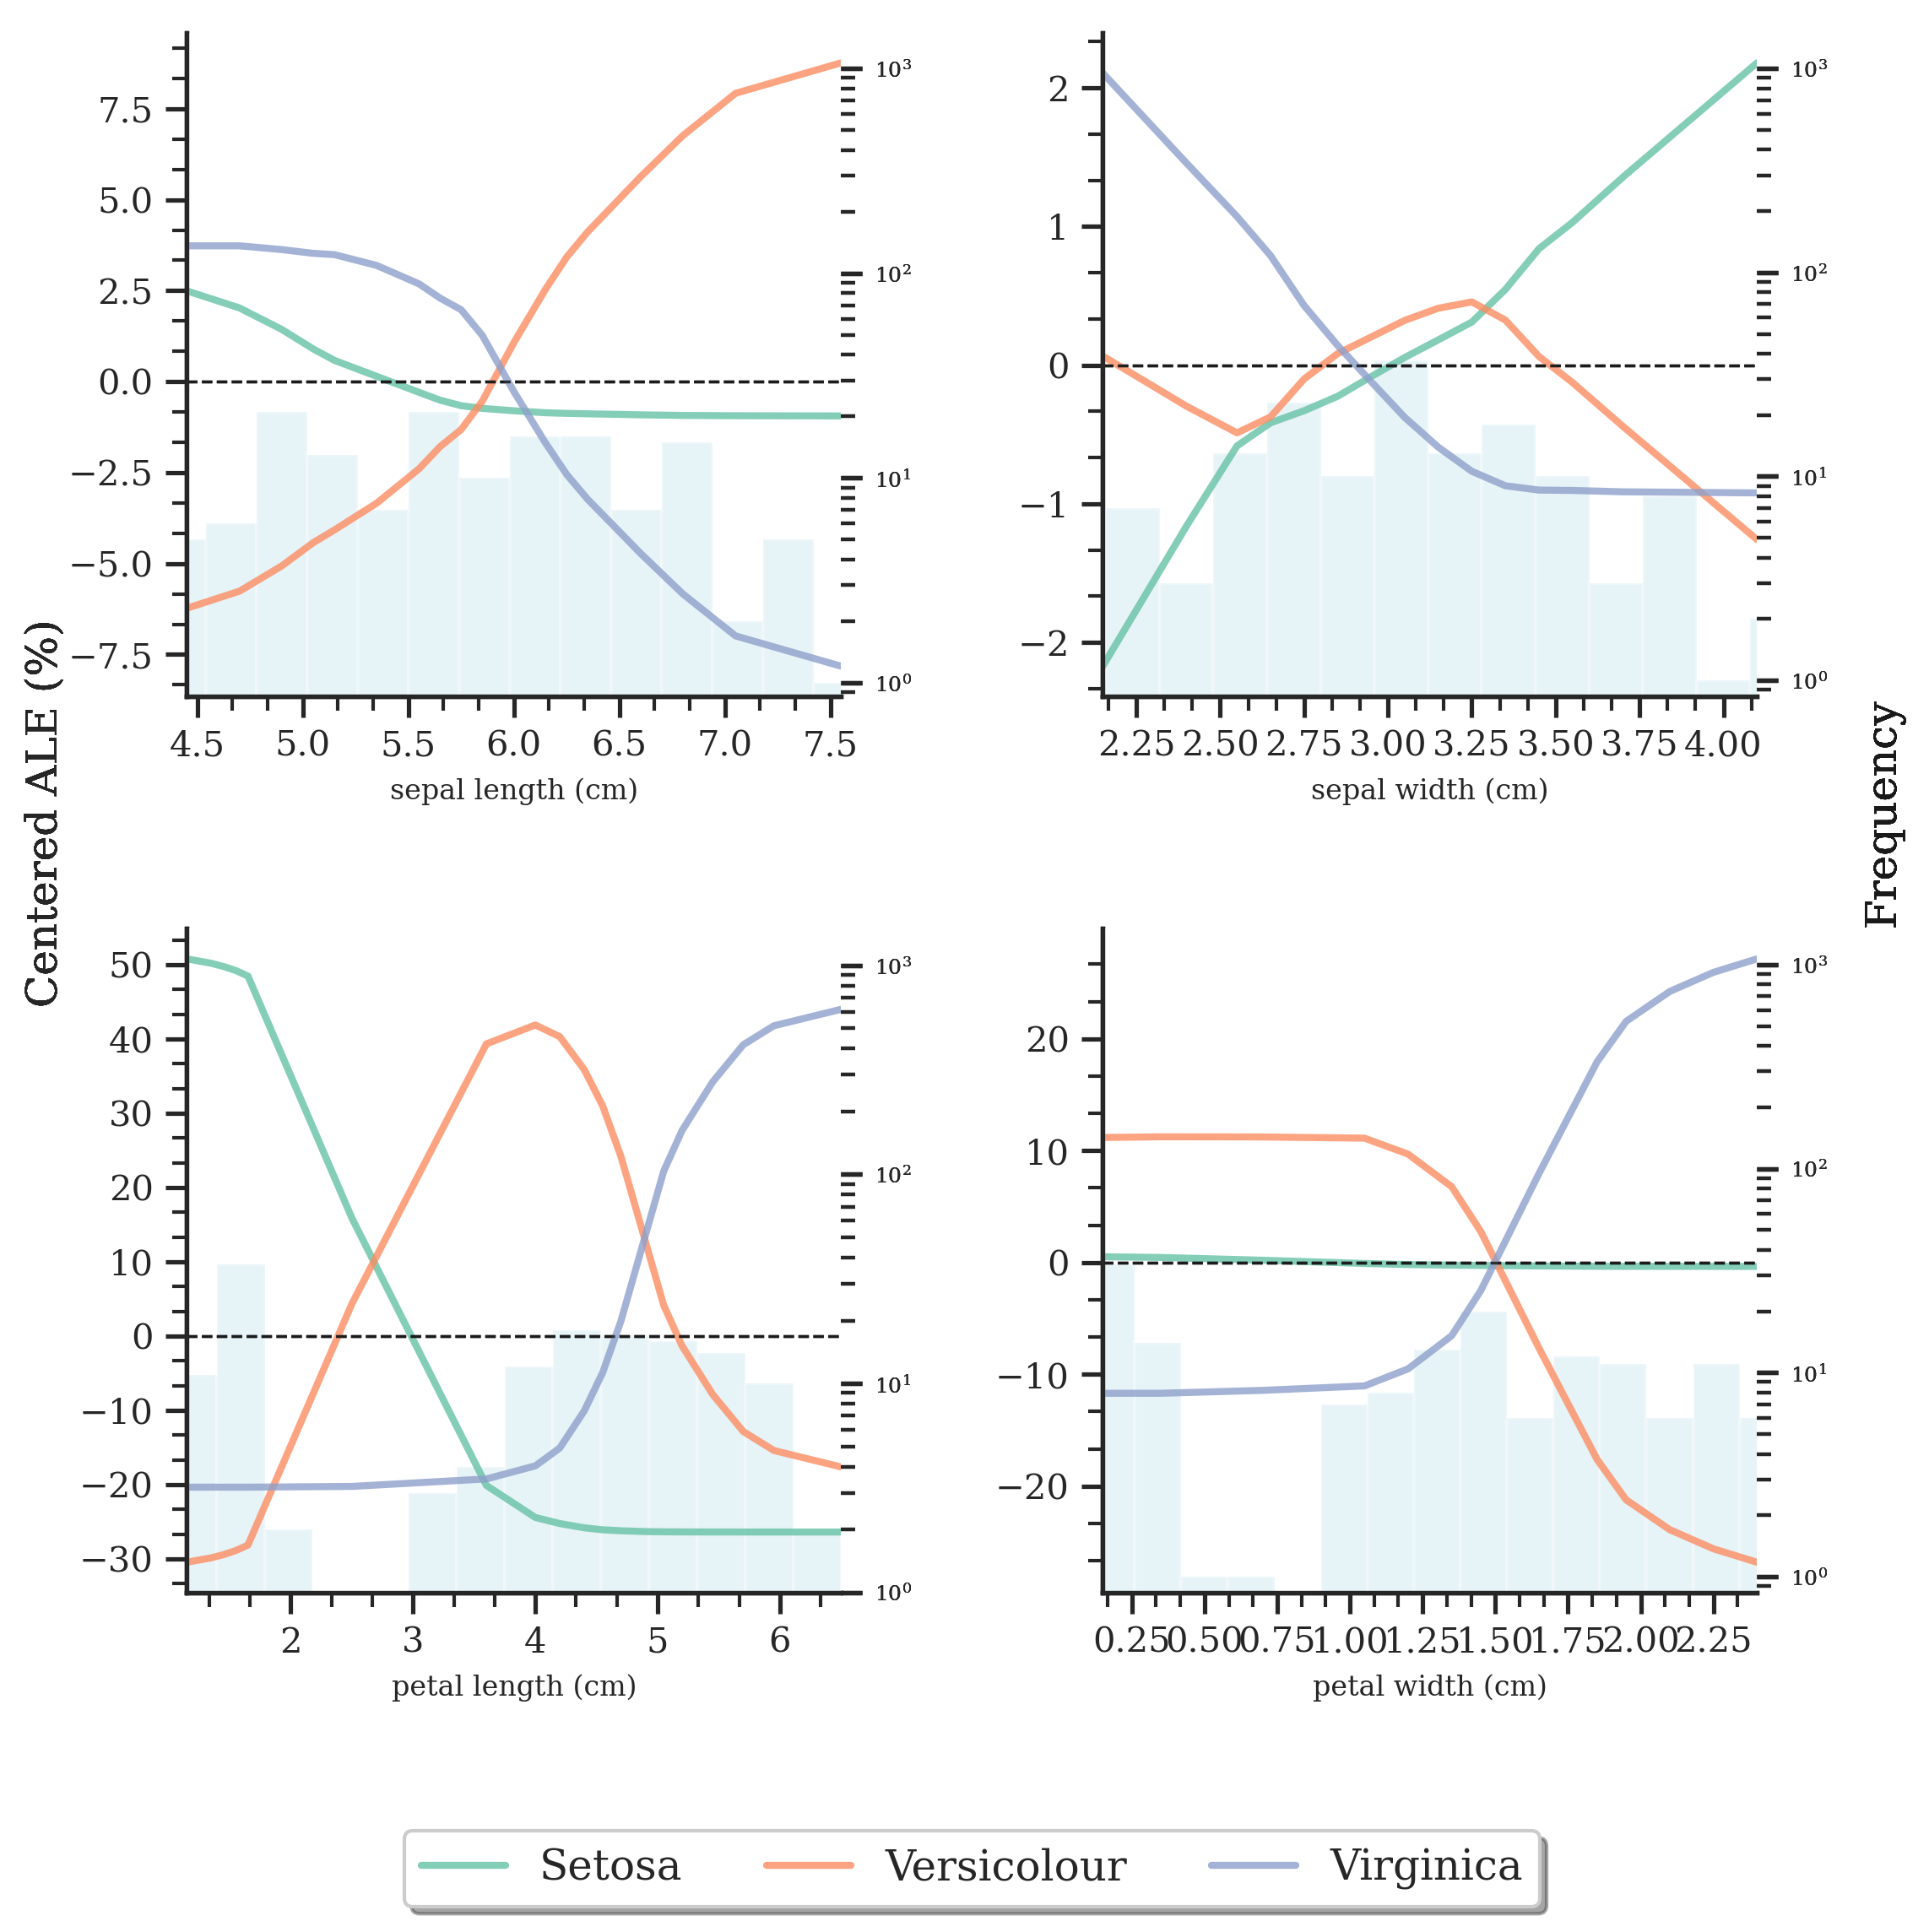

In [6]:
from skexplain.plot.base_plotting import PlotStructure
import seaborn as sns

features = X.columns
n_panels=len(features)
plotter= PlotStructure(BASE_FONT_SIZE = 16)
fig, axes = plotter.create_subplots(n_panels=len(features), n_columns=2, figsize=(8,8), dpi=300, 
                                      wspace=0.4, hspace=0.35)

colors = list(sns.color_palette("Set2"))
for ax, feature in zip(axes.flat, features):
    for i, ale in enumerate(ales): 
        explainer.plot_ale(ale = ale, 
                           features=feature, 
                           ax=ax, line_kws = {'line_colors' : [colors[i]],
                                              'linewidth': 2.0}, 
                          )
        
# Add legend 
plotter.set_legend(n_panels, fig, ax, labels=['Setosa', 'Versicolour', 'Virginica'])

### MultiClass SHAP 

In this example, we show case how to show SHAP for a single class. 

In [7]:
np.unique(y)

array([0, 1, 2])

In [8]:
results = []
for class_idx in np.unique(y):
    shap_kws={'masker' : shap.maskers.Partition(X, max_samples=10, clustering="correlation"), 
           'algorithm' : 'permutation', 'class_idx' : class_idx}

    results.append( explainer.local_attributions(method='shap', 
                                       shap_kws=shap_kws,
                                          )
                  )

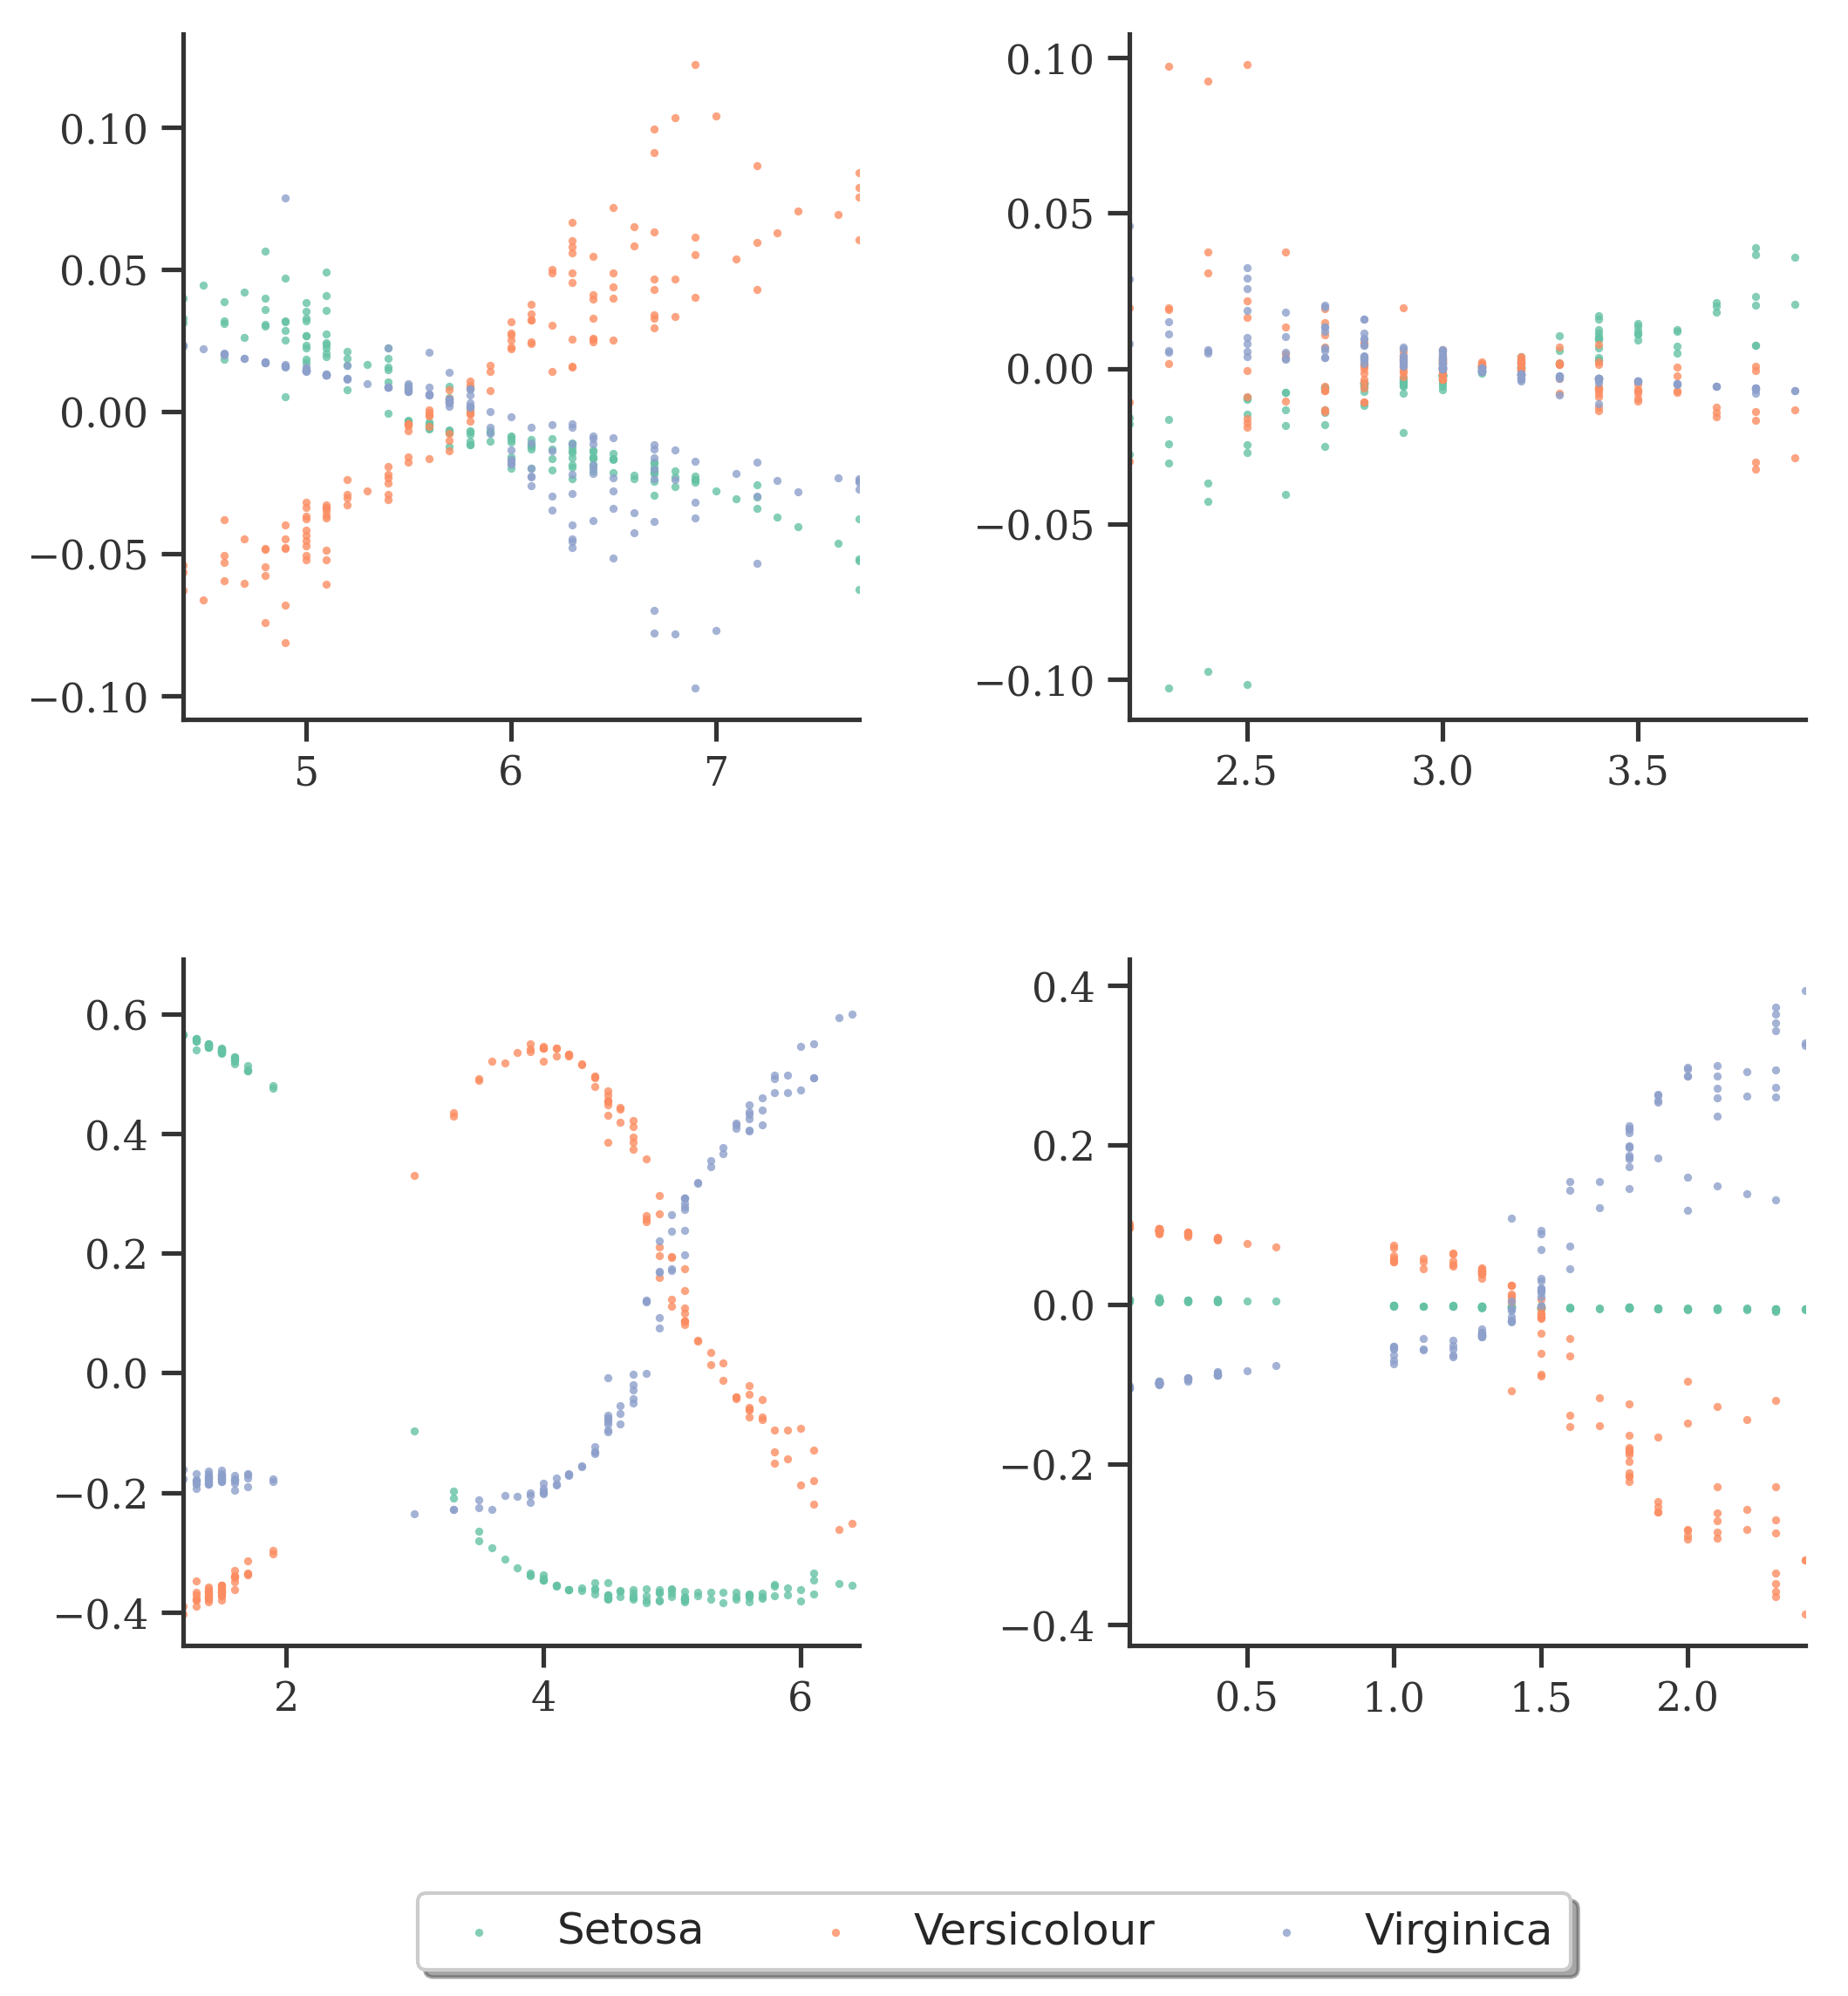

In [9]:
from skexplain.plot.base_plotting import PlotStructure
import seaborn as sns

features = X.columns
n_panels=len(features)
plotter= PlotStructure(BASE_FONT_SIZE = 16)
fig, axes = plotter.create_subplots(n_panels=len(features), n_columns=2, figsize=(8,8), dpi=300, 
                                      wspace=0.4, hspace=0.35)

colors = list(sns.color_palette("Set2"))
for ax, feature in zip(axes.flat, features):
    for i, shap_vals in enumerate(results): 
        explainer.scatter_plot(features=[feature],
                    plot_type = 'dependence',
                    dataset=shap_vals,
                    method = ['shap'], 
                    estimator_name = 'LogisticRegression',
                    color = colors[i],
                    interaction_index=None, 
                    ax=ax, 
     )
        
        
# Add legend 
plotter.set_legend(n_panels, fig, ax, labels=['Setosa', 'Versicolour', 'Virginica'])